<a href="https://colab.research.google.com/github/hiiiiiiiiiieve/Anomaly-Detection/blob/main/LSTM-AE%2Cthreshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd

df1 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2011.csv")
df2 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2012.csv")
df3 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2013.csv")
df4 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2014.csv")
df5 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2015.csv")
gt_at = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
gt_at = gt_at[['AT']]

# LSTM-Autoencoder activation
## relu

Epoch 1/50
1148/1148 [==============================] - 42s 33ms/step - loss: 0.0296
Epoch 2/50
1148/1148 [==============================] - 37s 32ms/step - loss: 0.0032
Epoch 3/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0029
Epoch 4/50
1148/1148 [==============================] - 35s 31ms/step - loss: 0.0027
Epoch 5/50
1148/1148 [==============================] - 39s 34ms/step - loss: 0.0021
Epoch 6/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0016
Epoch 7/50
1148/1148 [==============================] - 36s 31ms/step - loss: 0.0014
Epoch 8/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0014
Epoch 9/50
1148/1148 [==============================] - 36s 31ms/step - loss: 0.0011
Epoch 10/50
1148/1148 [==============================] - 39s 34ms/step - loss: 8.6164e-04
Epoch 11/50
1148/1148 [==============================] - 37s 32ms/step - loss: 8.6784e-04
Epoch 12/50
1148/1148 [==============================] 

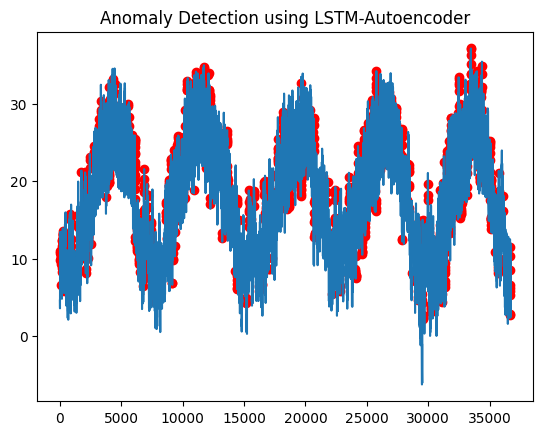

Number of anomalies: 1837


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 10  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    # 인코더
    encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 95)  # 95% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Epoch 1/50
1148/1148 [==============================] - 58s 47ms/step - loss: 0.0321
Epoch 2/50
1148/1148 [==============================] - 36s 31ms/step - loss: 0.0034
Epoch 3/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0029
Epoch 4/50
1148/1148 [==============================] - 37s 32ms/step - loss: 0.0027
Epoch 5/50
1148/1148 [==============================] - 36s 32ms/step - loss: 0.0018
Epoch 6/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0015
Epoch 7/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0015
Epoch 8/50
1148/1148 [==============================] - 37s 32ms/step - loss: 0.0014
Epoch 9/50
1148/1148 [==============================] - 37s 32ms/step - loss: 0.0014
Epoch 10/50
1148/1148 [==============================] - 35s 31ms/step - loss: 0.0011
Epoch 11/50
1148/1148 [==============================] - 38s 33ms/step - loss: 8.3985e-04
Epoch 12/50
1148/1148 [==============================] - 37

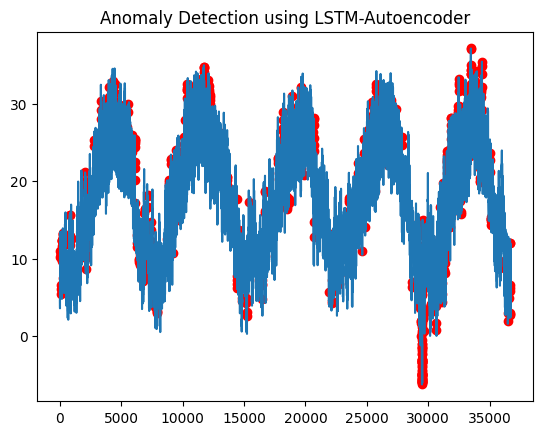

Number of anomalies: 919


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 10  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    # 인코더
    encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 97.5)  # 97.5% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

In [ ]:
#임계치 개수, 부분적으로 그래프 그려서 확인

스케일링 -> 모델에 대하여 이상치 예측 -> 비교(mse) -> 이상치 점수 스케일링(0~1) -> 비교(mse)